## Oxparis Visualization Notebook
In this notebook one can load images and gt from the oxparis dataset as given by the POLD2 team (they were givin it by remi).
Possible actions in this Notebook:
- Load Images from the dataset and look at it and GT
- Run model on image and compare result with gt
- also detect lines

In [1]:
import torch
import flow_vis
import numpy as np
from matplotlib import pyplot as plt
from gluefactory.datasets import get_dataset

In [2]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

dset_conf = {
            "reshape": None, # ex [800, 800]
            "load_features": {
                "do": True,
                "check_exists": True,
                "point_gt": {
                    "data_keys": ["superpoint_heatmap"],
                    "use_score_heatmap": False,
                },
                "line_gt": {
                    "data_keys": ["deeplsd_distance_field", "deeplsd_angle_field"],
                },
            },
            "debug": True
        }
oxpa_2 = get_dataset("oxford_paris_mini_1view_jpldd")(dset_conf)
ds = oxpa_2.get_dataset(split="train")

# load one test element
elem = ds[0]
elem.keys()

/local/home/Point-Line/jpl_venv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
[09/24/2024 23:38:04 gluefactory.datasets.base_dataset INFO] Creating dataset OxfordParisMiniOneViewJPLDD
[09/24/2024 23:38:04 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES: 12000


DATASET OVERALL(NO-SPLIT) IMAGES: 12000


[09/24/2024 23:38:05 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES WITH GT: 12000


dict_keys(['name', 'scales', 'image_size', 'transform', 'original_image_size', 'image', 'orig_points', 'superpoint_heatmap', 'deeplsd_distance_field', 'deeplsd_angle_field'])

AF: type: <class 'torch.Tensor'>, shape: torch.Size([768, 1024]), min: 0.0, max: 3.1415927410125732
DF: type: <class 'torch.Tensor'>, shape: torch.Size([768, 1024]), min: 0.2540781497955322, max: 9.183110237121582
KP-HMAP: type: <class 'torch.Tensor'>, shape: torch.Size([768, 1024]), min: 0.0, max: 1.0, sum: 1111.0


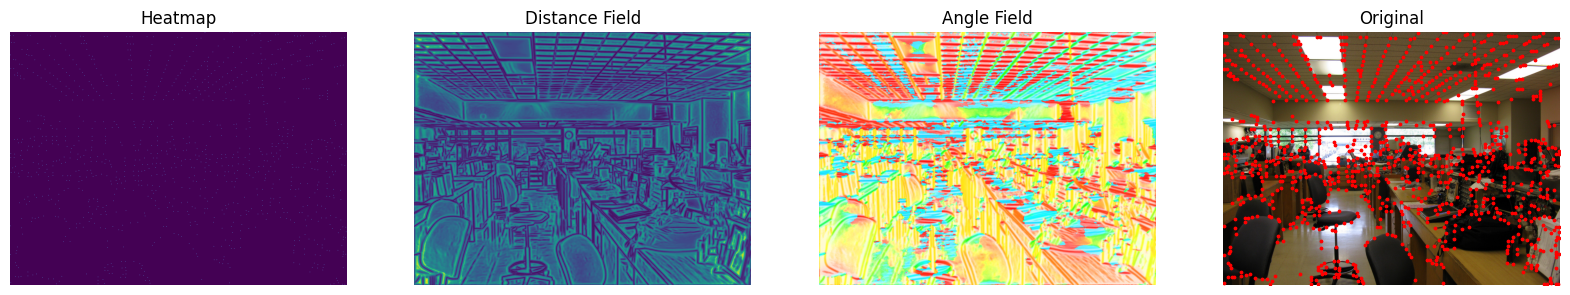

In [3]:
af = elem["deeplsd_angle_field"]
df = elem["deeplsd_distance_field"]
hmap = elem["superpoint_heatmap"]
orig_pt = elem["orig_points"]

print(f"AF: type: {type(af)}, shape: {af.shape}, min: {torch.min(af)}, max: {torch.max(af)}")
print(f"DF: type: {type(df)}, shape: {df.shape}, min: {torch.min(df)}, max: {torch.max(df)}")
print(f"KP-HMAP: type: {type(hmap)}, shape: {hmap.shape}, min: {torch.min(hmap)}, max: {torch.max(hmap)}, sum: {torch.sum(hmap)}")

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].axis('off')
ax[0].set_title('Heatmap')
ax[0].imshow(hmap)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(df, af))

ax[3].axis('off')
ax[3].set_title('Original')
ax[3].imshow(elem["image"].permute(1,2,0))
ax[3].scatter(orig_pt[:, 0], orig_pt[:, 1], marker="o", color="red", s=3)
plt.show()

## Run a model to get predictions

In [5]:
from gluefactory.models import get_model

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
device = 'cpu'
print(f"Device Used: {device}")

jpldd_conf = {
    "name": "joint_point_line_extractor",
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "timeit": True,  # override timeit: False from BaseModel
    "line_df_decoder_channels": 32,
    "line_af_decoder_channels": 32,
    "line_detection": {
        "do": False
    },
    "checkpoint": None#"/local/home/rkreft/shared_team_folder/outputs/training/rk_pold2gt_oxparis_base/checkpoint_best.tar"
}
jpldd_model = get_model("joint_point_line_extractor")(jpldd_conf).to(device)
jpldd_model.eval()

Device Used: cpu


JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [11]:
# add batch dim and move to device
img_torch = elem["image"].to(device).unsqueeze(0)
img_torch.shape

torch.Size([1, 3, 768, 1024])

In [13]:
%%time
with torch.no_grad():
    output_model = jpldd_model({"image": img_torch})
output_model.keys()

CPU times: user 28.1 s, sys: 1.43 s, total: 29.5 s
Wall time: 5.38 s


dict_keys(['keypoint_and_junction_score_map', 'line_anglefield', 'line_distancefield', 'keypoints_raw', 'keypoints', 'keypoint_scores', 'descriptors'])

In [14]:
# print shapes
jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0]
jpldd_af = output_model['line_anglefield'][0]
jpldd_df = output_model['line_distancefield'][0]
jpldd_kpr = output_model['keypoints_raw'][0]
jpldd_kp = output_model['keypoints'][0]
jpldd_kp_scores = output_model['keypoint_scores'][0]
jpldd_desc = output_model['descriptors'][0]

jpldd_kpjhm.shape, jpldd_af.shape, jpldd_df.shape, jpldd_kpr.shape, jpldd_kp.shape, jpldd_kp_scores.shape, jpldd_desc.shape

(torch.Size([768, 1024]),
 torch.Size([768, 1024]),
 torch.Size([768, 1024]),
 torch.Size([1024, 2]),
 torch.Size([1024, 2]),
 torch.Size([1024]),
 torch.Size([1024, 128]))

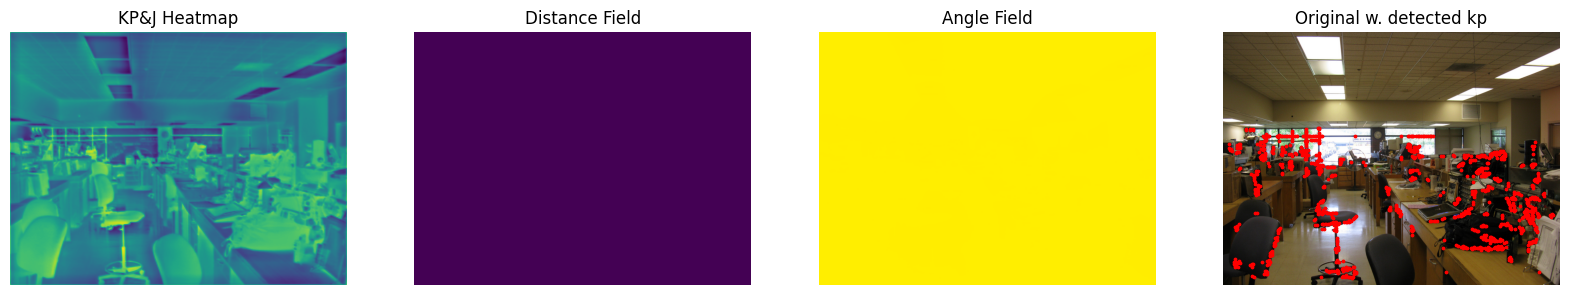

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].axis('off')
ax[0].set_title('KP&J Heatmap')
ax[0].imshow(jpldd_kpjhm)

ax[1].axis('off')
ax[1].set_title('Distance Field')
ax[1].imshow(jpldd_df)

ax[2].axis('off')
ax[2].set_title('Angle Field')
ax[2].imshow(get_flow_vis(jpldd_df, jpldd_af))

ax[3].axis('off')
ax[3].set_title('Original w. detected kp')
ax[3].imshow(img_torch.squeeze(0).permute(1,2,0))
ax[3].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)
plt.show()